# GANs

Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

A Generative Adversarial Network takes the following approach for generative modeling:

<img src="https://i.imgur.com/6NMdO9u.png" style="width:420px; margin-bottom:32px"/>

There are two neural networks: a *Generator* and a *Discriminator*.

The generator generates a "fake" sample given a random vector/matrix, and the discriminator attempts to detect whether a given sample is "real" (picked from the training data) or "fake" (generated by the generator).

Training happens in tandem: we train the discriminator for a few epochs, then train the generator for a few epochs, and repeat. This way both the generator and the discriminator get better at doing their jobs.

GANs can be notoriously difficult to train compared to Supervised Deep Neural Networks, and are extremely sensitive to hyperparameters, activation functions and regularization.

In this notebook, we'll train a GAN to generate images of anime characters' faces:

<img src="https://i.imgur.com/NaKtJs0.png" width="360" style="margin-bottom:32px"/>


We'll use the [Anime Face Dataset](https://github.com/Mckinsey666/Anime-Face-Dataset), which consists of over 63,000 cropped anime faces.

Note that generative modeling is an unsupervised learning task, so the images do not have any labels.

# Required imports

In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image

import os
from utils import get_default_device, DeviceDataLoader, to_device
from utils import get_environment_type, create_directory, move_path, run_command, CellStopExecution

import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Download anime faces dataset from kaggle

Copy the kaggle.json file for your kaggle account to the parent directory of this script before running next cell

In [8]:
nb_dir = os.path.abspath('')
kaggle_json_fpath = os.path.join(nb_dir, 'kaggle.json')

if not os.path.exists(kaggle_json_fpath):
    print('Error! Please copy your kaggle.json file to the current directory')
    raise CellStopExecution

user_root_dir = os.path.expanduser('~')
kaggle_root_dir = os.path.join(user_root_dir, '.kaggle')
create_directory(kaggle_root_dir)
target_path = os.path.join(kaggle_root_dir, 'kaggle.json')
move_path(kaggle_json_fpath, target_path)
run_command(['chmod', '600', target_path])

dataset_name_kaggle = 'splcher/animefacedataset'
run_command(['kaggle', 'datasets', 'download', '-d', dataset_name_kaggle])

dataset_name = dataset_name_kaggle.split('/')[1]
data_dir = os.path.join(nb_dir, dataset_name)
create_directory(data_dir)

dataset_zip_fpath = os.path.join(nb_dir, dataset_name + '.zip')
run_command(['unzip', '-o', '-q', dataset_zip_fpath, '-d', data_dir])

Directory C:\Users\Arnabjyoti Goswami\.kaggle already exists
Directory c:\Users\Arnabjyoti Goswami\Desktop\DCGAN-AnimeFaces\animefacedataset created successfully


''

## Loading the dataset into PyTorch

Let's load this dataset using the `ImageFolder` class from `torchvision`. We will also resize and crop the images to `64x64 px`, and normalize the pixel values with a mean & standard deviation of `0.5` for each channel. This will ensure that pixel values are in the range `(-1, 1)`, which is more  convenient for training the discriminator. We will also create a data loader to load the data in batches.

In [9]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [10]:
train_ds = ImageFolder(
    data_dir,
    transform = T.Compose([
        T.Resize(image_size),
        T.CenterCrop(image_size),
        T.ToTensor(),
        T.Normalize(*stats)
    ])
)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

## Helper functions to denormalize and view some images from a batch

In [11]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [12]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

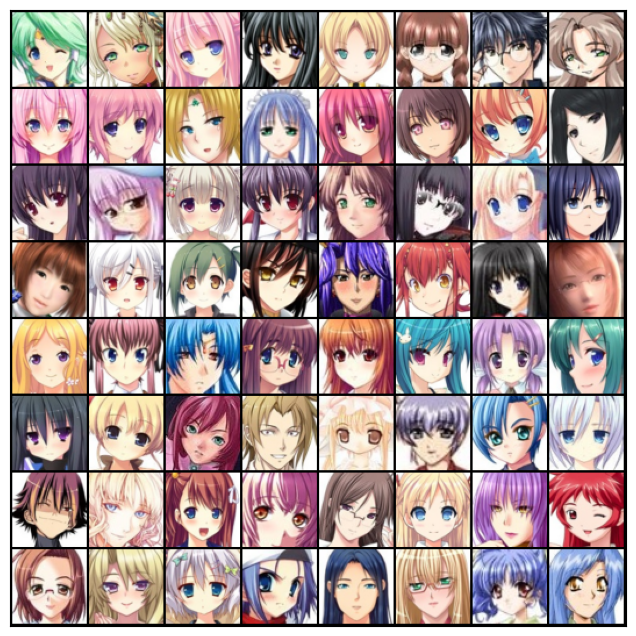

In [13]:
show_batch(train_dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's just a CNN classifier model. We'll use stride of 2 to progressively reduce the size of the output feature map, instead of a max pooling layer, for this CNN model.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [16]:
def ConvBlock(in_channels, out_channels):
    convblock = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2, inplace=True),
    )
    return convblock

In [17]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    ConvBlock(3, 64),
    # out: 64 x 32 x 32
    ConvBlock(64, 128),
    # out: 128 x 16 x 16
    ConvBlock(128, 256),
    # out: 256 x 8 x 8
    ConvBlock(256, 512),
    # out: 512 x 4 x 4
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1
    nn.Flatten(), # out: 1
    nn.Sigmoid(),
)

We're using the Leaky ReLU activation for the discriminator. Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient.

<img src="https://cdn-images-1.medium.com/max/1600/1*ypsvQH7kvtI2BhzR2eT_Sw.png" width="420">

In [18]:
discriminator = to_device(discriminator, device)

# Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*).

In [19]:
latent_size = 128

In [20]:
def deConvBlock(in_channels, out_channels, stride, padding):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True),
    )
    return block

## Formula for keeping track of shapes

`O = (I - K + 2P) / S + 1`

where:

O = output 2d matrix shape (in and out channels specified anyways so only need to find the 2d matrix shape)

I = input 2d matrix shape

K = Kernel Size

P = Padding

S = Stride

This needs to be applied in the reverse way, for e.g. 4x4 to 1x1 for the first layer, must be thought of as 1x1 (input) to 4x4 (output) as the generator model uses deconvolutions.

In [21]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    deConvBlock(latent_size, 512, stride=1, padding=0),
    # out: 512 x 4 x 4
    deConvBlock(512, 256, stride=2, padding=1),
    # out: 256 x 8 x 8
    deConvBlock(256, 128, stride=2, padding=1),
    # out: 128 x 16 x 16
    deConvBlock(128, 64, stride=2, padding=1),
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

We use the TanH activation function for the output layer of the generator.

<img src="https://nic.schraudolph.org/teach/NNcourse/figs/tanh.gif" width="420" >

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - [Source](https://arxiv.org/pdf/1511.06434.pdf)


Since the outputs of the TanH activation lie in the range `[-1,1]`, we have applied the **similar transformation to the images** in the training dataset.

Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output. The output from the generator is basically random noise, since we haven't trained it yet.

torch.Size([128, 3, 64, 64])


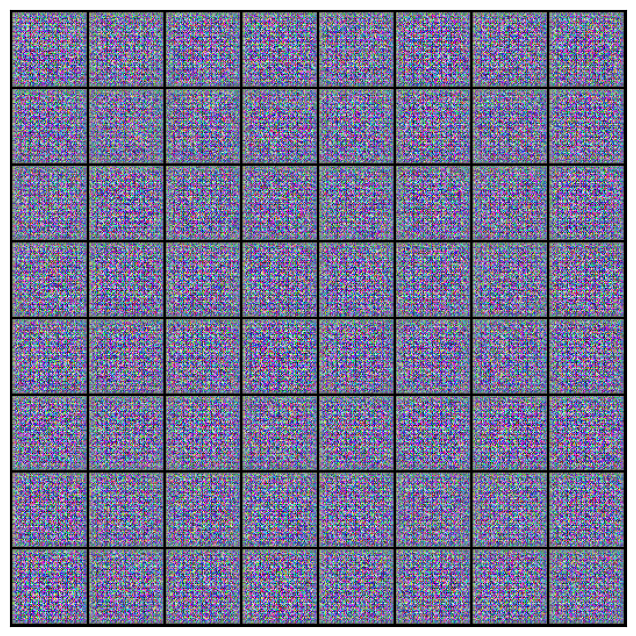

In [22]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [23]:
generator = to_device(generator, device)

# Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >


Steps involved in training the discriminator:

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network.

- We first pass a batch of real images, and compute the loss, setting the target labels to 1.

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

In [24]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

Steps involved in training the generator:

- We generate a batch of images using the generator, pass the into the discriminator.

- We calculate the loss by setting the target labels to 1 i.e. real. We do this because the generator's objective is to "fool" the discriminator.

- We use the loss to perform gradient descent i.e. change the weights of the generator, so it gets better at generating real-like images to "fool" the discriminator.

In [25]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images using the generator
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Take predictions for the generated fake images from the discriminator
    preds = discriminator(fake_images)
    # Set those fake images labels as true images (targets)
    targets = torch.ones(batch_size, 1, device=device)
    # Calculate loss between the predictions and the targets
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

# Make a directory to store results of training

In [26]:
generator_dir = 'generated_images'
create_directory(generator_dir)

Directory generated_images already exists


In [27]:
def save_samples(index, latent_tensors, dir_path, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    fake_fpath = os.path.join(dir_path, fake_fname)
    save_image(denorm(fake_images), fake_fpath, nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model. Let's save one set of images before we start training our model.

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [29]:
save_samples(0, fixed_latent, dir_path=generator_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


# Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>


In [30]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl, total=len(train_dl),
                                   desc=f'Training discriminator and generator for epoch {epoch + start_idx}'):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False, dir_path=generator_dir)

    return losses_g, losses_d, real_scores, fake_scores

# Training the DCGAN

In [31]:
# Hyperparameters
lr = 0.0002
epochs = 25

In [33]:
history = fit(epochs, lr)

Training discriminator and generator for epoch 1:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 5.0566, loss_d: 0.5940, real_score: 0.9011, fake_score: 0.3570
Saving generated-images-0001.png


Training discriminator and generator for epoch 2:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 4.9408, loss_d: 0.4087, real_score: 0.8664, fake_score: 0.1963
Saving generated-images-0002.png


Training discriminator and generator for epoch 3:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 2.7115, loss_d: 0.1731, real_score: 0.9108, fake_score: 0.0512
Saving generated-images-0003.png


Training discriminator and generator for epoch 4:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 6.0705, loss_d: 0.5173, real_score: 0.6951, fake_score: 0.0039
Saving generated-images-0004.png


Training discriminator and generator for epoch 5:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 3.7711, loss_d: 0.1405, real_score: 0.9203, fake_score: 0.0343
Saving generated-images-0005.png


Training discriminator and generator for epoch 6:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 6.9713, loss_d: 0.6485, real_score: 0.6228, fake_score: 0.0006
Saving generated-images-0006.png


Training discriminator and generator for epoch 7:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 6.1464, loss_d: 0.1520, real_score: 0.9500, fake_score: 0.0837
Saving generated-images-0007.png


Training discriminator and generator for epoch 8:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 5.8059, loss_d: 0.2891, real_score: 0.8102, fake_score: 0.0029
Saving generated-images-0008.png


Training discriminator and generator for epoch 9:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 6.0710, loss_d: 0.0941, real_score: 0.9738, fake_score: 0.0451
Saving generated-images-0009.png


Training discriminator and generator for epoch 10:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 6.8705, loss_d: 0.0726, real_score: 0.9585, fake_score: 0.0223
Saving generated-images-0010.png


Training discriminator and generator for epoch 11:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 13.2496, loss_d: 0.0001, real_score: 0.9999, fake_score: 0.0000
Saving generated-images-0011.png


Training discriminator and generator for epoch 12:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 5.1411, loss_d: 0.0388, real_score: 0.9862, fake_score: 0.0228
Saving generated-images-0012.png


Training discriminator and generator for epoch 13:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 12.2500, loss_d: 0.0230, real_score: 0.9872, fake_score: 0.0087
Saving generated-images-0013.png


Training discriminator and generator for epoch 14:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 7.5133, loss_d: 0.2333, real_score: 0.8587, fake_score: 0.0009
Saving generated-images-0014.png


Training discriminator and generator for epoch 15:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 6.4750, loss_d: 0.2021, real_score: 0.8868, fake_score: 0.0080
Saving generated-images-0015.png


Training discriminator and generator for epoch 16:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 6.5136, loss_d: 0.0774, real_score: 0.9706, fake_score: 0.0396
Saving generated-images-0016.png


Training discriminator and generator for epoch 17:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 18.7245, loss_d: 0.0248, real_score: 0.9786, fake_score: 0.0003
Saving generated-images-0017.png


Training discriminator and generator for epoch 18:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 10.1607, loss_d: 0.0515, real_score: 0.9923, fake_score: 0.0391
Saving generated-images-0018.png


Training discriminator and generator for epoch 19:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 15.5567, loss_d: 1.8777, real_score: 0.3785, fake_score: 0.0000
Saving generated-images-0019.png


Training discriminator and generator for epoch 20:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 12.5177, loss_d: 0.2101, real_score: 0.9433, fake_score: 0.0964
Saving generated-images-0020.png


Training discriminator and generator for epoch 21:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 16.3900, loss_d: 0.0269, real_score: 0.9796, fake_score: 0.0048
Saving generated-images-0021.png


Training discriminator and generator for epoch 22:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 16.0282, loss_d: 0.0033, real_score: 0.9972, fake_score: 0.0002
Saving generated-images-0022.png


Training discriminator and generator for epoch 23:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 11.8599, loss_d: 0.0101, real_score: 0.9980, fake_score: 0.0077
Saving generated-images-0023.png


Training discriminator and generator for epoch 24:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.7994, loss_d: 0.0210, real_score: 0.9887, fake_score: 0.0086
Saving generated-images-0024.png


Training discriminator and generator for epoch 25:   0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.8949, loss_d: 0.0588, real_score: 0.9575, fake_score: 0.0061
Saving generated-images-0025.png


In [34]:
losses_g, losses_d, real_scores, fake_scores = history

In [35]:
# Save the model parameters after training
generator_params_fpath = os.path.join(nb_dir, 'trained_weights', 'generator.pth')
discriminator_params_fpath = os.path.join(nb_dir, 'trained_weights', 'discriminator.pth')
torch.save(generator.state_dict(), generator_params_fpath)
torch.save(discriminator.state_dict(), discriminator_params_fpath)

In [38]:
def show_epoch_results(epoch):
    epoch_str = "{0:0=4d}".format(epoch)
    gen_images_fpath = os.path.join(nb_dir, generator_dir, f'generated-images-{epoch_str}.png')
    display(Image(filename=gen_images_fpath))

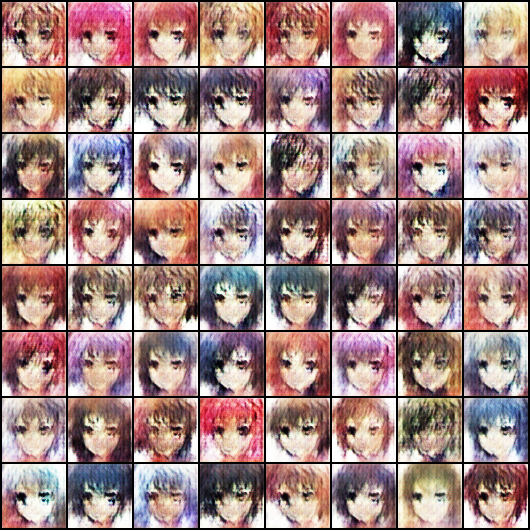

In [49]:
show_epoch_results(epoch=1)

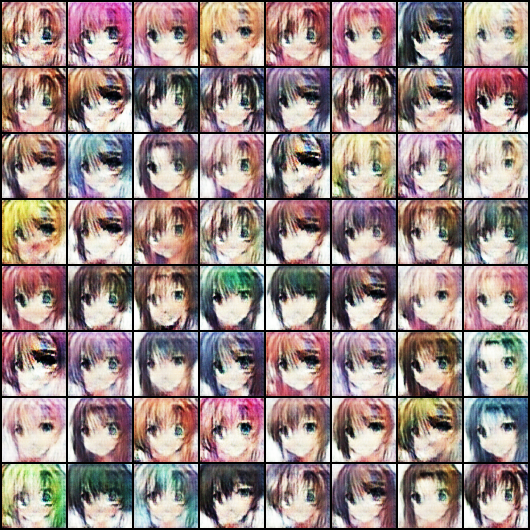

In [50]:
show_epoch_results(epoch=5)

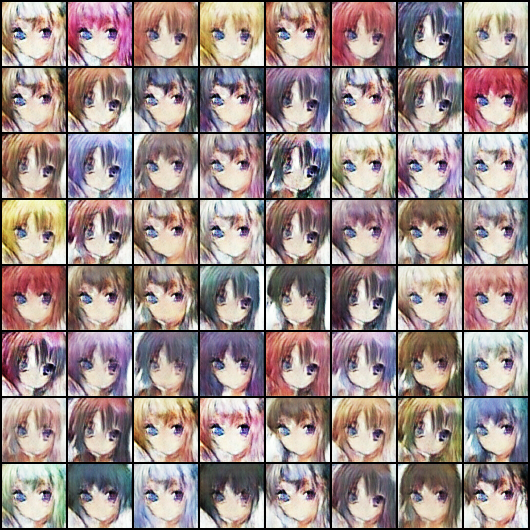

In [51]:
show_epoch_results(epoch=10)

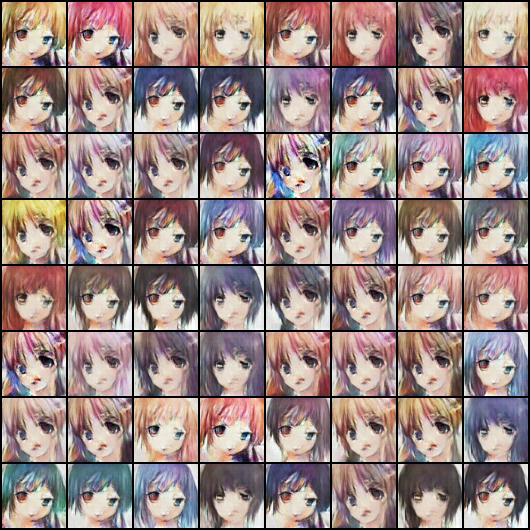

In [52]:
show_epoch_results(epoch=25)

# Visualizing training process by combining epoch images to a video

In [45]:
vid_fname = 'progress_video.avi'
vid_fpath = os.path.join(nb_dir, vid_fname)

files = [os.path.join(generator_dir, f) for f in os.listdir(generator_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fpath, cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

# Visualizing losses progression over training

For GANs, we expect the generator's loss to reduce over time, without the discriminator's loss getting too high. Although this doesn't really matter as much due to it being an unsupervised learning algorithm, the main thing is that its outputs should match what we would generally expect after seeing some samples from the dataset.

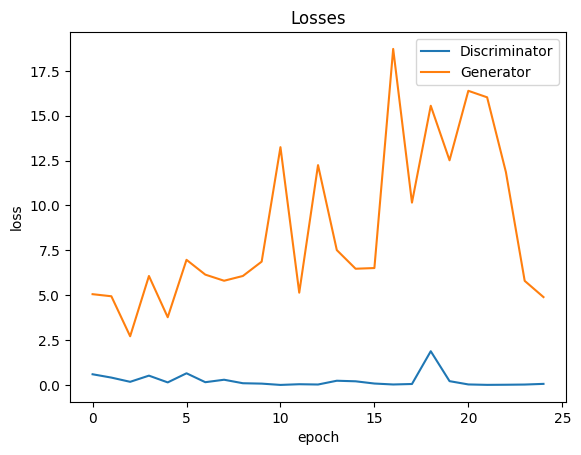

In [46]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()

In [47]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')
plt.show()

# Download generated files from this google colab session (skip if using local system)

In [48]:
if get_environment_type() == 'colab':
    generator_results_zip_fpath = os.path.join(nb_dir, f"{generator_dir.split('/')[-1]}.zip")
    !zip -r $generator_results_zip_fpath $generator_dir

    from google.colab import files
    files.download(generator_results_zip_fpath)

    files.download(discriminator_params_fpath)
    files.download(generator_params_fpath)

    files.download(vid_fpath)